# First things first

Let's import all the fun stuff that lets us do the really fun stuff.

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
 
INDIR = "/kaggle/input"
OUTDIR = "/kaggle/working"
DBNAME = "words.db"
 
pd.options.plotting.backend = "matplotlib"
figs = {}

# Prepping the data

We're going to load our words from the word lists that we copied from the source code. There are two lists, one which seems to be a list of played words and ones that have yet to be released.

In [2]:


played_words = pd.read_json("../input/wordle-word-list/played_words.json")
unplayed_words = pd.read_json("../input/wordle-word-list/unplayed_words.json")

played_words[1] = True
unplayed_words[1] = False

words = pd.concat([played_words, unplayed_words])
words.columns = ["name", "played"]
words.reset_index()

words.describe()

,name,played
count,12972,12972
unique,12972,2
top,cigar,False
freq,1,10657


# Our first heuristic

Let's see how many times each letter is used in the entire wordle word list and present as a nice little bar graph.

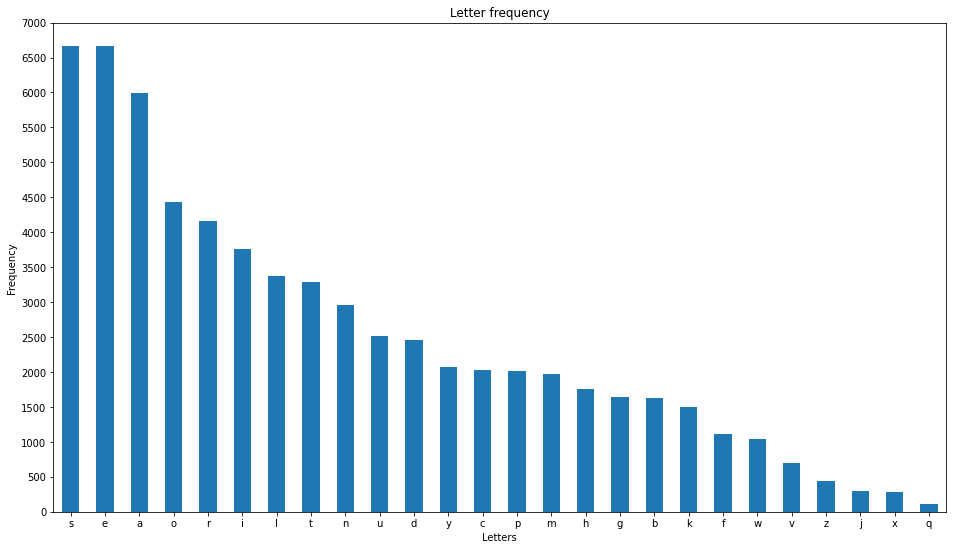

In [3]:
from itertools import chain

letters = pd.Series(chain.from_iterable(words["name"]))
figs["letter_freq.png"] =letters.value_counts().plot(
    kind="bar",
    title="Letter frequency",
    figsize=(16,9),
    xlabel="Letters",
    ylabel="Frequency",
    yticks=range(0, 7001, 500),
    rot=0
)

From the above, we can see that the top 5 letters are: s, e, a, o and r. Let's see how many words in the list are made up of these letters.

In [4]:
def contains_all(letters):
    return lambda word:  set(letters) <= set(word)

all_top5_letters = words["name"].apply(contains_all("seaor"))
words[all_top5_letters]

,name,played
1252,arose,True
112,aeros,False
8530,soare,False


So, how many words can we test for just by playing these words?

In [5]:
def contains_any(letters):
    return lambda word: len(set(letters) & set(word)) > 0

any_top5_letter = words["name"].apply(contains_any("seaor"))
words[any_top5_letter].describe()

,name,played
count,12395,12395
unique,12395,2
top,cigar,False
freq,1,10263


So what does that mean for us? Well, to answer that, look at it this way: what's our worst possible scenario? Simply, that none of letters we played make up the secret word. In this case, we've still managed to do away with a great deal of the problem space, out of a total 12,972 words we've eliminated 12,395. Using only 1/6th of the time given to us, we've eliminated 95% of the problem. Let's filter for any possible words using the next 5 most common letters.

In [6]:
words_turn2 = words[~any_top5_letter]

all_next5_letters = words_turn2["name"].apply(contains_all("intlu"))
words_turn2[all_next5_letters]

,name,played
444,unlit,True
986,until,True


So we have two words that use the letters ranking 6 through 10. Again, our worst case scenario is that none of these letters our in the secret word. How many possibilities have we eliminated?

In [7]:
any_next5_letters = words_turn2["name"].apply(contains_any("until"))
words_turn2[any_next5_letters].describe()

,name,played
count,574,574
unique,574,2
top,humph,False
freq,1,392


Two turns done, and we have eliminated 12,969 (12,395 + 574) words. By turn 3, this means that we have the following possiblities left. Even if we ignore the clues dropped by the game, in three more turns, we'll have the answer.

In [8]:
words_turn3 = words_turn2[~any_next5_letters]
words_turn3

,name,played
2132,pygmy,True
3836,gyppy,False
4261,hyphy,False


# How about another strategy

Let's try to get as many vowels done as fast as we can. We're going to find out exactly how many unique vowels each word has, while we're at it, we'll count them too.

In [9]:
def get_unique_letters(letters):
    return lambda word: ''.join(sorted(set(letters) & set(word)))

words["vowels"] = words["name"].apply(get_unique_letters("aeiou"))
words["vowel_count"] = words["vowels"].str.len()

filter_max_vowels = words["vowel_count"] == words["vowel_count"].max()
words[filter_max_vowels]

,name,played,vowels,vowel_count
1589,audio,True,aiou,4
88,adieu,False,aeiu,4
517,auloi,False,aiou,4
526,aurei,False,aeiu,4
5320,louie,False,eiou,4
5673,miaou,False,aiou,4
6472,ouija,False,aiou,4
6480,ourie,False,eiou,4
9796,uraei,False,aeiu,4


How about we plot out the vowel combos to see to see how many times they're used in the wordle list.

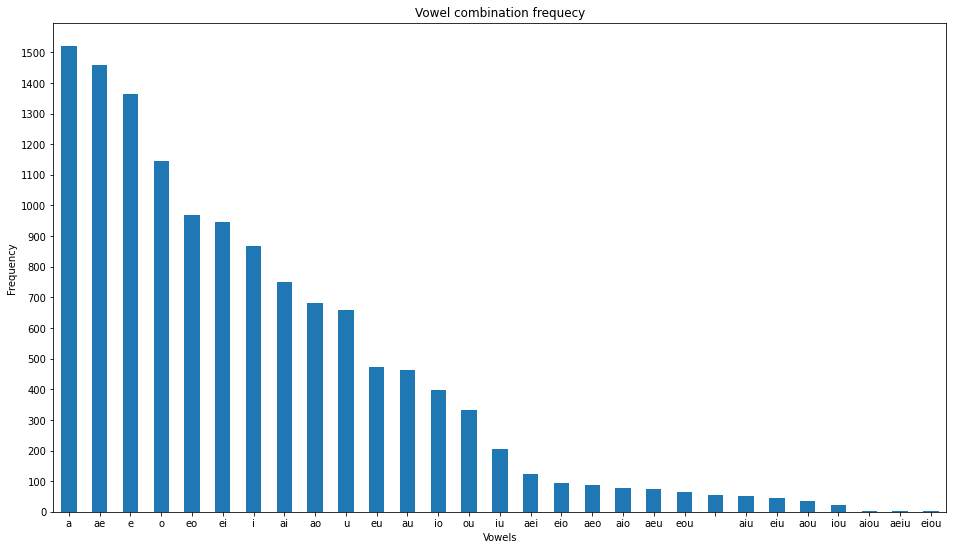

In [10]:
figs["vowel_combo_freq.png"] = words["vowels"].value_counts().plot(
    kind="bar",
    title="Vowel combination frequecy",
    figsize=(16,9),
    xlabel="Vowels",
    ylabel="Frequency",
    yticks=range(0,1501,100),
    rot=0
)

# How about brute force?

We tried out some heuristics above to find a good starting move, but let's put all this compute power to use. We're going to find how many words can be matched to at least one letter for every word in the word list. Since this takes some time, we're going to pop those results for future use into a SQLite db. If a DB exists, we'll load the data from there, otherwise, we'll do all that work all over again.

In [11]:
from sqlalchemy import create_engine

def count_matches(words):
    return lambda word: words.apply(
        contains_any(word)
    ).value_counts()[True] - 1

try:
    # If there is is a db with a table, use it
    db_path = os.path.join(INDIR, "wordle-word-list", DBNAME)
    cxn = create_engine(f"sqlite:///{db_path}")
    words = pd.read_sql("SELECT * FROM words", cxn)
except:
    # Otherwise, build the results from scratch and save to db
    db_path = os.path.join(OUTDIR, DBNAME)
    words["starter_score"] = words["name"].apply(count_matches(words["name"]))
    cxn = create_engine(f"sqlite:///{db_path}")
    words.to_sql("words", cxn, if_exists="replace", index=False)
else:
    # When loading from db, map "played" to boolean
    words["played"] = words["played"].map({0: False, 1: True})   

words[words["starter_score"] == words["starter_score"].max()]

,name,played,vowels,vowel_count,starter_score
11125,stoae,False,aeo,3,12416
11688,toeas,False,aeo,3,12416


As it turns out, there are two words in the word list that just barely outperform our starter words consisting of the top 5 letter:
1. Stoae
2. Toeas

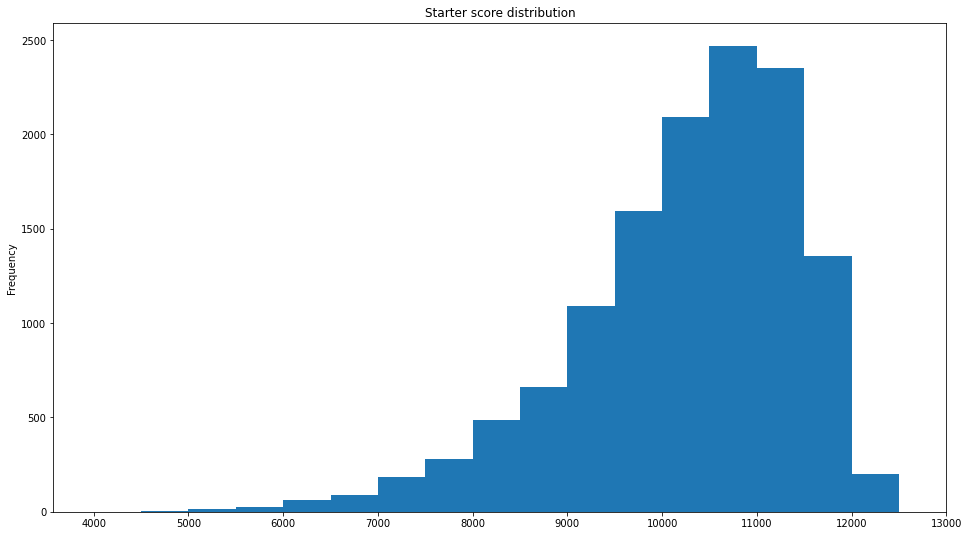

In [12]:
figs["starter_score_dist.png"] = words["starter_score"].plot(
    kind="hist",
    bins=range(4000, 13000, 500),
    title="Starter score distribution",
    figsize=(16,9),
    xticks=range(4000, 14000, 1000)
)

In [13]:
words["vowel_count"].corr(words["starter_score"])

0.45713066277481695

# Don't mind me
Just saving the plots

In [14]:
for name, axes in figs.items():
    axes.figure.savefig(name)